<a href="https://colab.research.google.com/github/palakagl/NepalEarthquake/blob/main/Richter_Prediction_Nepal_Earthquake_Optuna_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install xgboost
!pip install lightgbm
!pip install optuna

     |████████████████████████████████| 308 kB 5.4 MB/s 
     |████████████████████████████████| 80 kB 8.3 MB/s 
     |████████████████████████████████| 209 kB 36.4 MB/s 
     |████████████████████████████████| 75 kB 3.6 MB/s 
     |████████████████████████████████| 112 kB 36.8 MB/s 
     |████████████████████████████████| 49 kB 5.2 MB/s 
     |████████████████████████████████| 149 kB 42.5 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=d301baa27cb4240c24a9a9eb78e90feae64d91ac6500251b6dbc2d2fefcd6170
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [ ]:
import pandas as pd
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns

import optuna
import xgboost as xgb
import lightgbm as lgb

from xgboost import XGBClassifier

from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate,KFold, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

pd.set_option('display.max_columns', 70)

### 1. Load Data

In [ ]:
# Load Training data target labels
train_labels_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Richter-Predictor/train_labels.csv")
# Load Training data
train_data_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Richter-Predictor/train_values.csv")

# Load testing data
test_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Richter-Predictor/test_values.csv")
#test_data = pd.read_csv("test_values.csv")

In [ ]:
#Print training data sample
test_data.head()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,300051,17,596,11307,3,20,7,6,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
1,99355,6,141,11987,2,25,13,5,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,1,1,0,0,0,0,0,0,0,0,0
2,890251,22,19,10044,2,5,4,5,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
3,745817,26,39,633,1,0,19,3,t,r,x,v,j,t,d,0,0,0,0,0,1,0,0,0,0,0,v,2,1,0,0,1,0,0,0,0,0,0,0
4,421793,17,289,7970,3,15,8,7,t,r,q,f,q,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Add training labels to training dataset
train_data_df['damage_grade']=train_labels_df['damage_grade']
#train_data_df =pd.read_csv("train_data.csv")

### 2. Univariate Analysis

In [ ]:
train_data_df.describe().T

,count,mean,std,min,25%,50%,75%,max
building_id,260601.0,525675.482773,304544.999032,4.0,261190.0,525757.0,789762.0,1052934.0
geo_level_1_id,260601.0,13.900353,8.033617,0.0,7.0,12.0,21.0,30.0
geo_level_2_id,260601.0,701.074685,412.710734,0.0,350.0,702.0,1050.0,1427.0
geo_level_3_id,260601.0,6257.876148,3646.369645,0.0,3073.0,6270.0,9412.0,12567.0
count_floors_pre_eq,260601.0,2.129723,0.727665,1.0,2.0,2.0,2.0,9.0
age,260601.0,26.535029,73.565937,0.0,10.0,15.0,30.0,995.0
area_percentage,260601.0,8.018051,4.392231,1.0,5.0,7.0,9.0,100.0
height_percentage,260601.0,5.434365,1.918418,2.0,4.0,5.0,6.0,32.0
has_superstructure_adobe_mud,260601.0,0.088645,0.284231,0.0,0.0,0.0,0.0,1.0
has_superstructure_mud_mortar_stone,260601.0,0.761935,0.425900,0.0,1.0,1.0,1.0,1.0


In [ ]:
train_data_df.info()  # All columns are numerical, including Target variable

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260601 entries, 0 to 260600
Data columns (total 40 columns):
 #   Column                                  Non-Null Count   Dtype 
---  ------                                  --------------   ----- 
 0   building_id                             260601 non-null  int64 
 1   geo_level_1_id                          260601 non-null  int64 
 2   geo_level_2_id                          260601 non-null  int64 
 3   geo_level_3_id                          260601 non-null  int64 
 4   count_floors_pre_eq                     260601 non-null  int64 
 5   age                                     260601 non-null  int64 
 6   area_percentage                         260601 non-null  int64 
 7   height_percentage                       260601 non-null  int64 
 8   land_surface_condition                  260601 non-null  object
 9   foundation_type                         260601 non-null  object
 10  roof_type                               260601 non-null 

In [ ]:
train_data_df.nunique()

building_id                               260601
geo_level_1_id                                31
geo_level_2_id                              1414
geo_level_3_id                             11595
count_floors_pre_eq                            9
age                                           42
area_percentage                               84
height_percentage                             27
land_surface_condition                         3
foundation_type                                5
roof_type                                      3
ground_floor_type                              5
other_floor_type                               4
position                                       4
plan_configuration                            10
has_superstructure_adobe_mud                   2
has_superstructure_mud_mortar_stone            2
has_superstructure_stone_flag                  2
has_superstructure_cement_mortar_stone         2
has_superstructure_mud_mortar_brick            2
has_superstructure_c

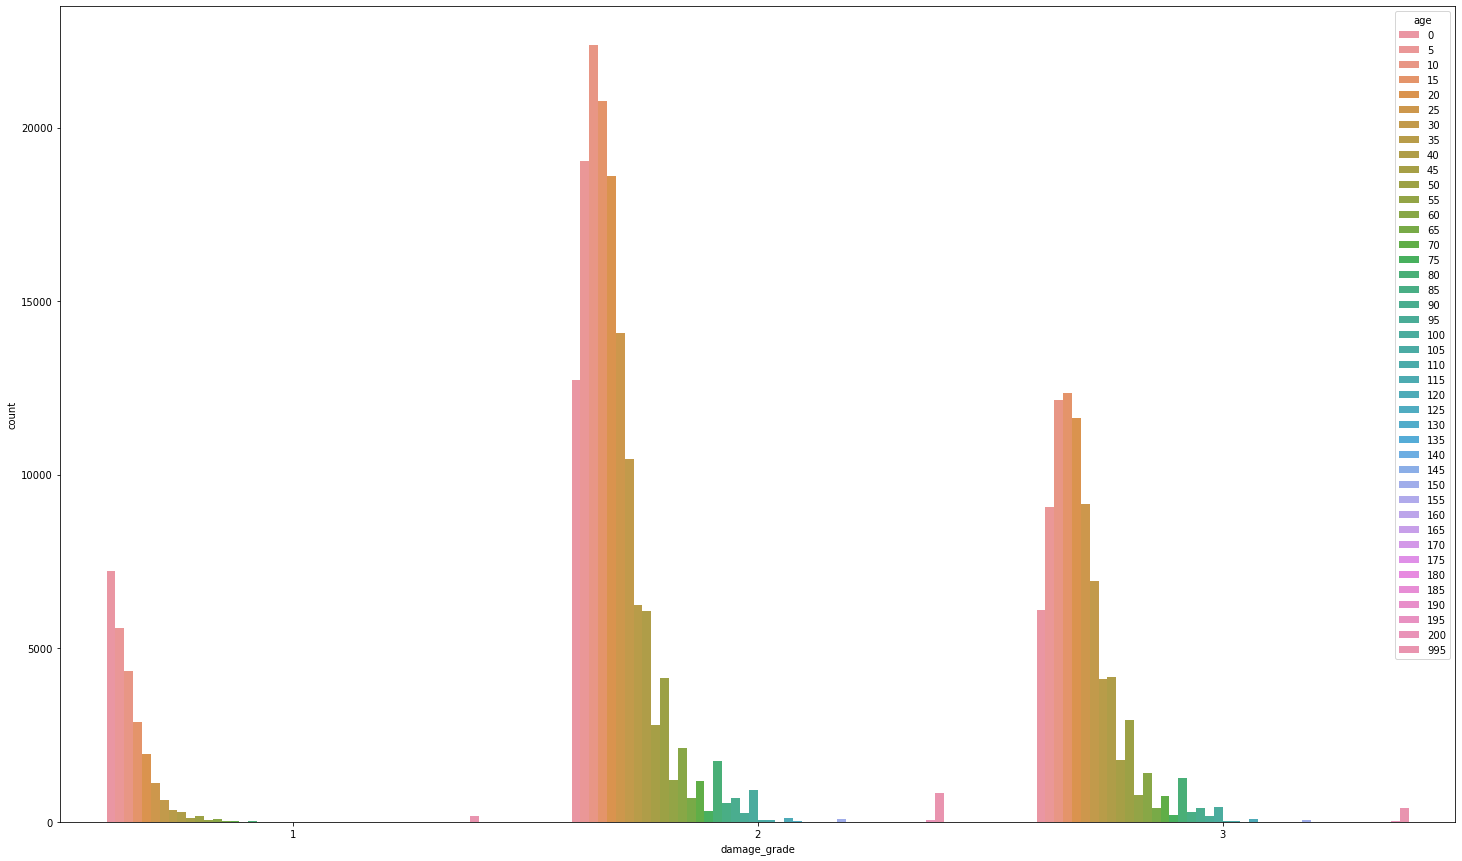

In [ ]:
# Checking train data labels distribution with age of the building
plt.figure(figsize=(25,15))
sns.countplot(data=train_data_df, x="damage_grade", hue="age")
plt.show()

** Note** -
Above graph clearly shows unbalanced data where we have far more data for damage grade '2', compare to other two. Also, building age distribution shows that in all 3 grades, older buildings are more suceptible to damage.

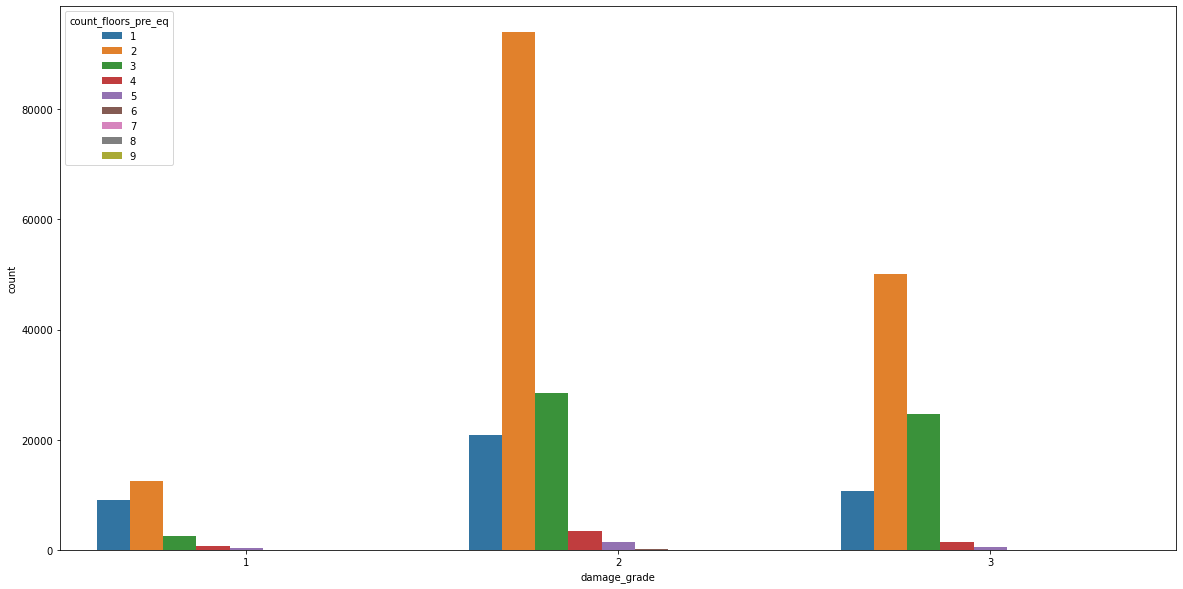

In [ ]:
# Checking train data labels distribution with age of the building
plt.figure(figsize=(20,10))
sns.countplot(data=train_data_df, hue="count_floors_pre_eq", x="damage_grade")
plt.show()

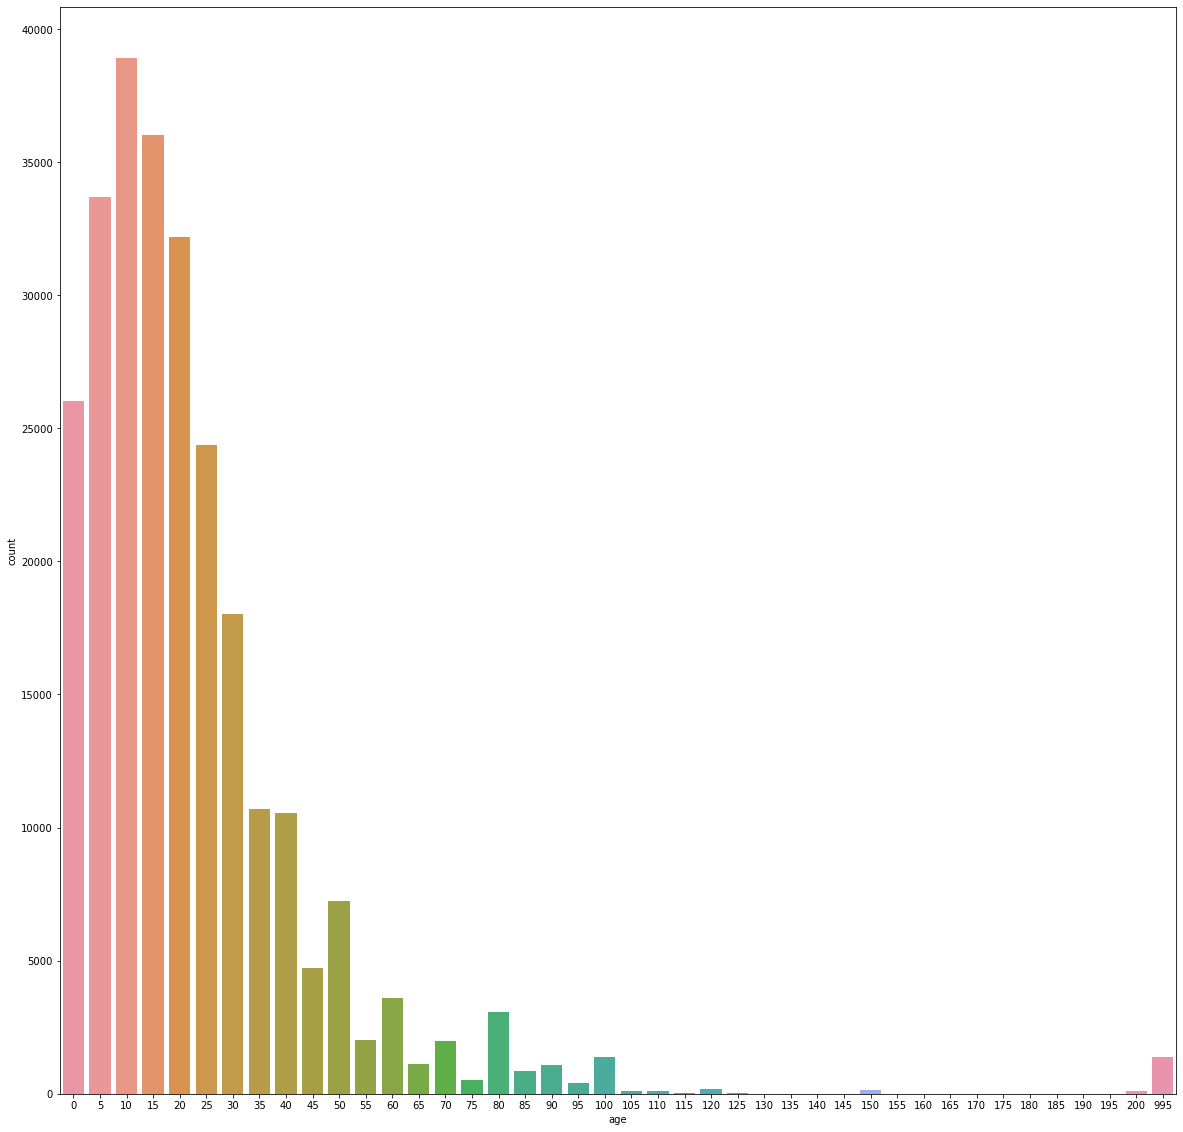

In [ ]:
# plot building age distribution
plt.figure(figsize = (20,20))
sns.countplot(train_data_df['age'])
plt.show()

# Check Duplicates in data

In [ ]:
##Identify duplicates records in the training data
dupes = train_data_df.duplicated()
sum(dupes)

0

In [ ]:
##Identify duplicates records in the test data
dupes = test_data.duplicated()
sum(dupes)

0

In [ ]:
train_data_df.corr()

,damage_grade,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
damage_grade,1.000000,0.001063,-0.072347,0.043161,0.007932,0.122308,0.029273,-0.125221,0.048130,0.055314,0.291325,0.066039,-0.060295,0.014561,-0.254131,-0.069852,-0.063051,-0.158145,-0.179014,-0.030224,0.056151,-0.079630,0.011309,-0.097942,-0.083754,-0.028728,-0.011692,-0.011024,-0.008543,-0.009378,-0.001656,-0.016334
building_id,0.001063,1.000000,-0.002850,0.000347,-0.000393,-0.000654,-0.001476,-0.002070,0.000096,-0.000307,0.002423,0.001443,-0.000827,-0.003768,0.001933,0.001967,0.001266,0.002472,-0.002259,0.002171,-0.000599,0.002606,0.002631,0.001934,-0.002152,0.000706,-0.000362,0.002348,-0.000374,0.000538,-0.003116,-0.002295
geo_level_1_id,-0.072347,-0.002850,1.000000,-0.061405,0.002718,-0.089364,-0.003908,0.071158,-0.063474,-0.018245,-0.152038,0.007677,0.023656,-0.028854,0.134121,0.144985,0.074169,0.016454,0.015767,0.022670,0.035108,-0.010428,-0.019786,0.001911,0.023523,0.003700,0.002977,0.002655,-0.002303,0.001060,0.000523,-0.017992
geo_level_2_id,0.043161,0.000347,-0.061405,1.000000,0.000921,0.047730,0.012594,-0.049443,0.035516,0.015833,0.076491,-0.008743,-0.009122,0.014246,-0.079875,-0.023927,-0.032588,-0.038173,-0.036074,-0.020144,-0.012439,-0.001519,0.017522,-0.008439,-0.030704,-0.004840,-0.004856,0.000687,-0.000757,-0.000152,0.001926,-0.013068
geo_level_3_id,0.007932,-0.000393,0.002718,0.000921,1.000000,-0.021646,-0.006385,-0.005643,-0.024507,-0.015732,0.026294,0.019579,0.005966,-0.023278,-0.005116,-0.003916,0.006143,0.002265,-0.012420,-0.010604,-0.002479,0.007375,0.015995,-0.002001,-0.007356,-0.007058,-0.004373,-0.000862,-0.002632,-0.000943,0.000269,-0.002463
count_floors_pre_eq,0.122308,-0.000654,-0.089364,0.047730,-0.021646,1.000000,0.086668,0.101071,0.772734,0.174852,-0.027116,-0.041058,-0.011329,0.257279,-0.085821,-0.056637,-0.070487,0.007448,0.049000,-0.029888,0.086586,0.052125,-0.005294,0.077120,0.035425,0.016384,0.008833,-0.002611,0.006786,0.009639,0.003939,-0.002073
age,0.029273,-0.001476,-0.003908,0.012594,-0.006385,0.086668,1.000000,-0.004323,0.061074,0.068032,0.001321,0.009129,-0.012128,0.079525,-0.036992,0.005855,-0.008374,-0.025431,-0.025552,-0.001520,0.005309,-0.008788,-0.002194,-0.010021,0.001193,-0.004189,-0.003514,-0.003658,-0.002169,-0.001764,-0.001195,-0.004534
area_percentage,-0.125221,-0.002070,0.071158,-0.049443,-0.005643,0.101071,-0.004323,1.000000,0.196645,0.026287,-0.225541,-0.000473,0.073701,0.053362,0.210800,-0.053965,-0.031641,0.185047,0.224647,0.007928,0.088630,0.122401,-0.016478,0.159885,0.105983,0.052212,0.050164,0.019421,0.015109,0.015290,0.004983,0.013111
height_percentage,0.048130,0.000096,-0.063474,0.035516,-0.024507,0.772734,0.061074,0.196645,1.000000,0.149725,-0.106573,-0.020260,0.012960,0.209098,0.001698,-0.052402,-0.063342,0.086228,0.129698,-0.019266,0.064316,0.091780,-0.005390,0.123551,0.068909,0.031366,0.020032,0.001946,0.011192,0.014660,0.004048,0.005397
has_superstructure_adobe_mud,0.055314,-0.000307,-0.018245,0.015833,-0.015732,0.174852,0.068032,0.026287,0.149725,1.000000,-0.306861,0.006962,-0.014554,0.314979,-0.037549,0.011694,0.011528,-0.036830,-0.036782,0.057545,0.033068,-0.013300,-0.003917,-0.012642,-0.003935,-0.004281,-0.002369,0.001762,-0.003292,-0.002648,-0.001493,-0.010074


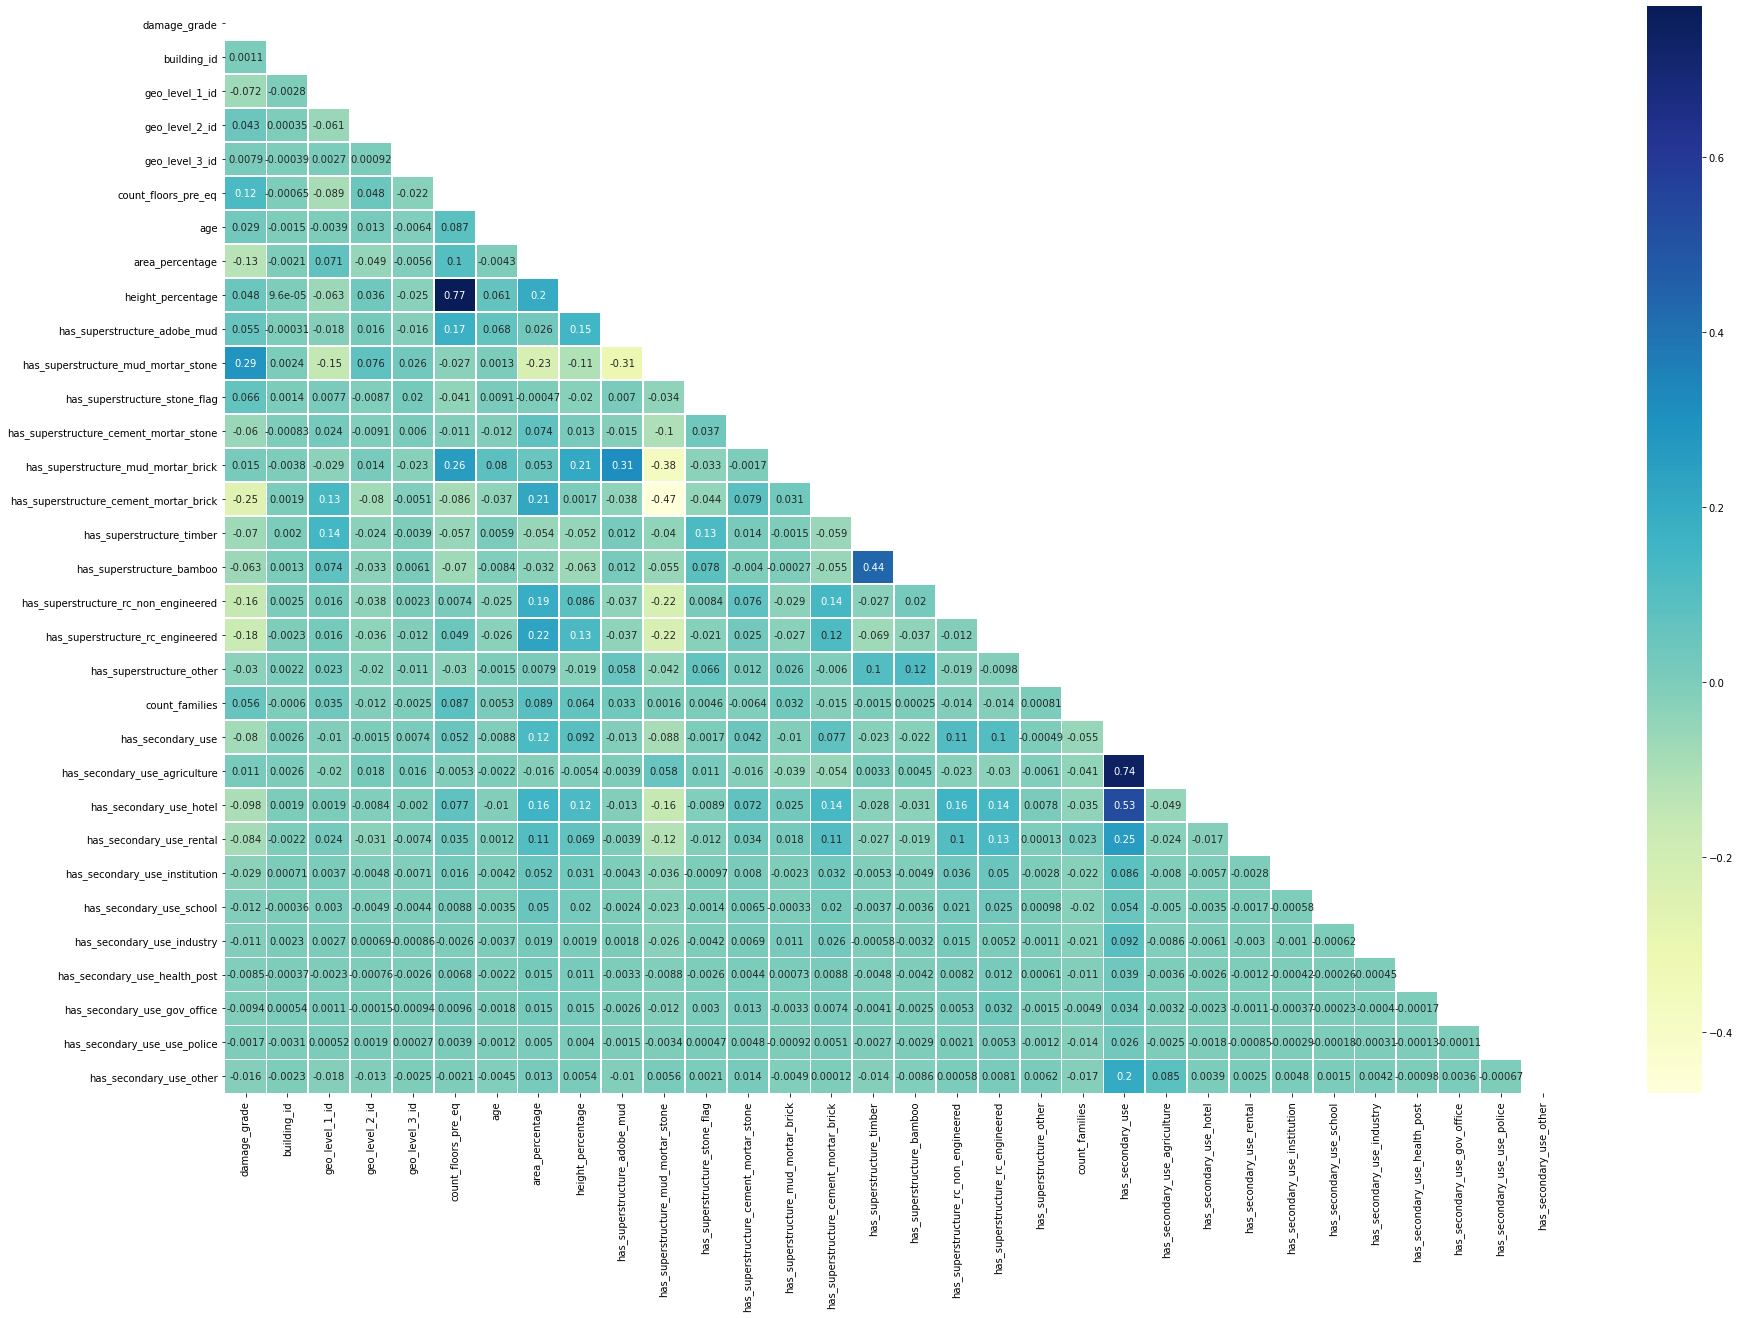

In [ ]:
plt.figure(figsize=(30,20))
corr= train_data_df.corr()
# Getting the Upper Triangle of the co-relation matrix
matrix = np.triu(corr)
sns.heatmap(corr, mask=matrix, annot=True, cmap="YlGnBu", linewidths=.8)  # plot the correlation coefficients as a heatmap
plt.show()

## Feature Engineering

In [ ]:
def pre_process(train_data, test_data, fillna_dict = {}, drop_list = []):
    test_train_data = pd.concat([train_data, test_data], ignore_index=True, axis=0)
        
    # Step 1: Fill missing values
    for col, fill_value in fillna_dict.items():
        test_train_data[col] = test_train_data[col].fillna(value=fill_value)
        
     # Step 2: Add features    
    test_train_data['building_volume_percentage'] = test_train_data['area_percentage'] * test_train_data['height_percentage']
       
    # Step 3: Drop columns
    test_train_data.drop(columns=drop_list, inplace=True, errors='ignore')
    
    test_train_data = pd.get_dummies(test_train_data).reset_index(drop=True)
    
    new_train_data = test_train_data.iloc[:len(train_data), :]
    new_test_data = test_train_data.iloc[len(train_data):, :]
    X_train = new_train_data.drop('damage_grade', axis=1)
    y_train = pd.DataFrame(new_train_data['damage_grade'].values.ravel()).astype(int)
    X_test = new_test_data.drop('damage_grade', axis=1)
    return X_train, y_train, X_test
    

In [ ]:
fillna_dict = {}
drop_list = ['building_id','has_secondary_use_agriculture','has_secondary_use_hotel','height_percentage','area_percentage']

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

X, y, X_test = pre_process(train_data_df.copy(),
                          test_data.copy(),
                           fillna_dict=fillna_dict,
                           drop_list=drop_list
                          )

print(X.shape)
print(X_test.shape)
X

(260601, 65)
(86868, 65)


,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,count_families,has_secondary_use,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,building_volume_percentage,land_surface_condition_n,land_surface_condition_o,land_surface_condition_t,foundation_type_h,foundation_type_i,foundation_type_r,foundation_type_u,foundation_type_w,roof_type_n,roof_type_q,roof_type_x,ground_floor_type_f,ground_floor_type_m,ground_floor_type_v,ground_floor_type_x,ground_floor_type_z,other_floor_type_j,other_floor_type_q,other_floor_type_s,other_floor_type_x,position_j,position_o,position_s,position_t,plan_configuration_a,plan_configuration_c,plan_configuration_d,plan_configuration_f,plan_configuration_m,plan_configuration_n,plan_configuration_o,plan_configuration_q,plan_configuration_s,plan_configuration_u,legal_ownership_status_a,legal_ownership_status_r,legal_ownership_status_v,legal_ownership_status_w
0,6,487,12198,2,30,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,30,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0
1,8,900,2812,2,10,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,56,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
2,21,363,8973,2,10,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,25,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0
3,22,418,10694,2,10,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,30,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
4,11,131,1488,3,30,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,72,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260596,25,1335,1621,1,55,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,18,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
260597,17,715,2060,2,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,30,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
260598,17,51,8163,3,55,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,42,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
260599,26,39,1851,2,10,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,84,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0


# Model Building

**Let's try following algorithms:**

* Random forest
* XGBoost

In [ ]:
RANDOM_SEED = 42

# 10-fold CV
kfolds = KFold(n_splits=10, shuffle=True, random_state=RANDOM_SEED)

### Random Forest

In [ ]:
# Fitting Random Forest Classification to the Training set
rf = RandomForestClassifier(random_state = RANDOM_SEED, max_depth = 15, 
                            n_estimators = 50, min_samples_split = 2, 
                            min_samples_leaf = 1)
rf.fit(X, y)

# predict the target on the train dataset
rf_predict_train = rf.predict(X)

# Accuray Score on train dataset
rf_accuracy_train = accuracy_score(y,rf_predict_train)
print('\nRandom Forest-accuracy_score on train dataset : ', rf_accuracy_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().




Random Forest-accuracy_score on train dataset :  0.6996366092225279


In [ ]:
#Store the accuracy results for each model in a dataframe for final comparison
resultsDf = pd.DataFrame({'Method':['Random Forest'], 'accuracy': [rf_accuracy_train]})
resultsDf = resultsDf[['Method', 'accuracy']]
resultsDf

NameError: ignored

In [ ]:
# Predict for test dataset
prediction=rf.predict(X_test)
rf_result=pd.DataFrame(prediction)

# Format the prediction as per submission requirement
rf_result['building_id']=test_data['building_id']
rf_result.rename(columns={0:'damage_grade'},inplace=True)
rf_result=rf_result[['building_id','damage_grade']]

rf_result.to_csv("drivendata_submission_rf.csv",index=False)

### XGBoost

In [ ]:
xgBoost = XGBClassifier(n_estimators=656, max_depth=9, reg_alpha=5, reg_lambda=0, min_child_weight=4, gamma=0, 
                learning_rate=0.0670973464914371, colsample_bytree=0.47, subsample=0.7869733332833408, num_boost_round=458.22748258637404)
xgBoost.fit(X, y)

# predict the target on the train dataset
xgBoost_predict_train = xgBoost.predict(X)

# Accuray Score on train dataset
xgBoost_accuracy_train = accuracy_score(y,xgBoost_predict_train)
print('\nXGBoost-accuracy_score on train dataset : ', xgBoost_accuracy_train)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().




XGBoost-accuracy_score on train dataset :  0.7777944060076516


In [ ]:
#Store the accuracy results for each model in a dataframe for final comparison
tempResultsDf = pd.DataFrame({'Method':['XGBoost'], 'accuracy': [xgBoost_accuracy_train]})
resultsDf = pd.concat([resultsDf, tempResultsDf])
resultsDf = resultsDf[['Method', 'accuracy']]
resultsDf

NameError: ignored

In [ ]:
# Predict for test dataset
prediction=xgBoost.predict(X_test)
xgBoost_result=pd.DataFrame(prediction)

# Format the prediction as per submission requirement
xgBoost_result['building_id']=test_data['building_id']
xgBoost_result.rename(columns={0:'damage_grade'},inplace=True)
xgBoost_result=xgBoost_result[['building_id','damage_grade']]

xgBoost_result.to_csv("drivendata_submission_xgBoost.csv",index=False)

# HyperParameter Tuning

### Hypertuning - XGBoost - RandomizedSearchCV

In [ ]:
# Param grid for Xgboost

n_jobs=[-1]
n_estimators=np.arange(100,1000,100)
learning_rate=[0.03,0.01,0.1]
max_depth=np.arange(10,100,15)

param_grid={'n_jobs':n_jobs,
            'n_estimators':n_estimators,
            'max_depth':max_depth,
            'learning_rate':learning_rate
           }

xgBoost_tune = XGBClassifier()

#rs=RandomizedSearchCV(xgBoost_tune,param_distributions=param_grid,cv=kfolds,scoring='f1_micro')

#rs.fit(X,y)

#rs.best_params_

In [ ]:
xgboost_rs_cv_clf=XGBClassifier(n_jobs=-1,n_estimators=500, max_depth=10,learning_rate= 0.1,colsample_bytree=0.5)
xgboost_rs_cv_clf.fit(X,y)

# Predict for test dataset
prediction=xgboost_rs_cv_clf.predict(X_test)
xgBoost_rs_cv_clf_result=pd.DataFrame(prediction)

# Format the prediction as per submission requirement
xgBoost_rs_cv_clf_result['building_id']=test_data['building_id']
xgBoost_rs_cv_clf_result.rename(columns={0:'damage_grade'},inplace=True)
xgBoost_rs_cv_clf_result=xgBoost_rs_cv_clf_result[['building_id','damage_grade']]

xgBoost_rs_cv_clf_result.to_csv("drivendata_submission_xgBoost_random_search_cv.csv",index=False)

G:\MyWorkSpace\Software\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
G:\MyWorkSpace\Software\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[02:12:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


### Stepwise Hypertuning - XGBoost - Optuna

### Optuna - Maximize Score Metrics

In [ ]:
import optuna 
from optuna import Trial, visualization
from optuna.samplers import TPESampler
from sklearn.model_selection import cross_val_score

In [ ]:
def objective(trial: Trial,X,y) -> float:

    param = {
                "n_estimators" : trial.suggest_int('n_estimators', 500, 1000),
                'max_depth':trial.suggest_int('max_depth', 2, 10),
                'reg_alpha':trial.suggest_int('reg_alpha', 0, 5),
                'reg_lambda':trial.suggest_int('reg_lambda', 0, 1, 10),
                'min_child_weight':trial.suggest_int('min_child_weight', 0, 5),
                'gamma':trial.suggest_int('gamma', 0, 0.25, 1),
                'learning_rate':trial.suggest_uniform('learning_rate',0, 0.1),
                'colsample_bytree':trial.suggest_discrete_uniform('colsample_bytree',0.1,0.5,0.01),
                'subsample':trial.suggest_float('subsample', 0.01, 1),
                'num_boost_round':trial.suggest_float('num_boost_round', 100,1000)
            }
    
    model = XGBClassifier(**param)
    
    return cross_val_score(model, X, y, cv=kfolds).mean()

In [ ]:
study = optuna.create_study(direction='maximize',sampler=TPESampler())
study.optimize(lambda trial : objective(trial,X,y),n_trials= 10)
print('Best trial: score {},\nparams {}'.format(study.best_trial.value,study.best_trial.params))

xgb_optuna_score_clf_best_params=study.best_trial.params

[I 2021-12-01 16:27:25,779] A new study created in memory with name: no-name-f8c8361a-1bfa-4a9e-baab-61b2de417c2b
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [0, 1] and step=10, but the range is not divisible by `step`. It will be replaced by [0, 0].

/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:563: UserWarning:

The distribution is specified by [0, 0.25] and step=1, but the range is not divisible by `step`. It will be replaced by [0, 0.0].

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel()

In [ ]:
xgb_optuna_score_clf = XGBClassifier(**xgb_optuna_score_clf_best_params, random_state=RANDOM_SEED, n_jobs=-1)
xgb_optuna_score_clf.fit(x_train, y_train);

# Predict for test dataset
prediction=xgb_optuna_score_clf.predict(X_test)
xgb_optuna_score_clf_result=pd.DataFrame(prediction)

# Format the prediction as per submission requirement
xgb_optuna_score_clf_result['building_id']=test_data['building_id']
xgb_optuna_score_clf_result.rename(columns={0:'damage_grade'},inplace=True)
xgb_optuna_score_clf_result=xgb_optuna_score_clf_result[['building_id','damage_grade']]

xgb_optuna_score_clf_result.to_csv("drivendata_submission_xgBoost_optuna_score.csv",index=False)

### Optuna - Maximize F1 Micro Score

In [ ]:
import xgboost as xgb
from optuna import create_study, logging
from optuna.pruners import MedianPruner
from optuna.integration import XGBoostPruningCallback

In [ ]:
score_func = metrics.f1_score
def score_function(y_pred, dtrain):
    y_pred = (y_pred > 0.5).astype(int)
    y_true = (dtrain.get_label() > 0.5).astype(int)
    return score_func.__name__, score_func(y_true, y_pred)

score_function.__name__ = score_func.__name__

def stepwise_optimization(trials=10):
    final_params = dict()
    for g in ['1', '2', '3']:
        print(f"=========================== Optimizing Group - {g} ============================")
        update_params = execute_optimization('xgboost', g, score_function, trials,
                                             params=final_params, direction='maximize')
        final_params.update(update_params)
        print(f"PARAMS after optimizing GROUP - {g}: ", final_params)
        print()
        print()

    print("=========================== FINAL OPTIMAL PARAMETERS ============================")
    print(final_params)
    
    return final_params


def objective(trial, X, y, group, score, params=dict()):
    dtrain = xgb.DMatrix(X, label=y)
    class_weight = (y.shape[0] - np.sum(y)) / np.sum(y)
    
    ## Initial Learning Parameters
    params['learning_rate'] = 0.1
    params['num_boost_round'] = 1000

    if group == '1':
        params['max_depth'] = trial.suggest_int('max_depth', 2, 10)
        params['min_child_weight'] = trial.suggest_loguniform('min_child_weight',
                                                              1e-10, 1e10)
    
    if group == '2':
        params['subsample'] = trial.suggest_uniform('subsample', 0, 1)
        params['colsample_bytree'] = trial.suggest_uniform('colsample_bytree', 0, 1)
    
    if group == '3':
        params['learning_rate'] = trial.suggest_uniform('learning_rate', 0, 0.1)
        params['num_boost_round'] = trial.suggest_int('num_boost_round', 100, 1000)

    pruning_callback = XGBoostPruningCallback(trial, "test-" + score.__name__)
    cv_scores = xgb.cv(params, dtrain, nfold=5,
                       stratified=True,
                       feval=score,
                       early_stopping_rounds=10,
                       callbacks=[pruning_callback],
                       seed=0)

    return cv_scores['test-' + score.__name__ + '-mean'].values[-1]


def execute_optimization(study_name, group, score, trials,
                         params=dict(), direction='maximize'):
    logging.set_verbosity(logging.ERROR)
    
    ## We use pruner to skip trials that are NOT fruitful
    pruner = MedianPruner(n_warmup_steps=5)
    
    study = create_study(direction=direction,
                         study_name=study_name,
                         storage='sqlite:///optuna.db',
                         load_if_exists=True,
                         pruner=pruner)

    study.optimize(lambda trial: objective(trial,X, y,group, score, params),
                   n_trials=trials,
                   n_jobs=-1)
    
    
    print("STUDY NAME: ", study_name)
    print('------------------------------------------------')
    print("EVALUATION METRIC: ", score.__name__)
    print('------------------------------------------------')
    print("BEST CV SCORE", study.best_value)
    print('------------------------------------------------')
    print(f"OPTIMAL GROUP - {group} PARAMS: ", study.best_params)
    print('------------------------------------------------')
    print("BEST TRIAL", study.best_trial)
    print('------------------------------------------------')
    
    
    return study.best_params

In [ ]:

xgb_optuna_f1_score_clf_best_params = stepwise_optimization()

xgb_optuna_f1_score_clf = XGBClassifier(**xgb_optuna_f1_score_clf_best_params, random_state=RANDOM_SEED, n_jobs=-1)
xgb_optuna_f1_score_clf.fit(x_train, y_train);

# Predict for test dataset
prediction=xgb_optuna_f1_score_clf.predict(X_test)
xgb_optuna_f1_score_clf_result=pd.DataFrame(prediction)

# Format the prediction as per submission requirement
xgb_optuna_f1_score_clf_result['building_id']=test_data['building_id']
xgb_optuna_f1_score_clf_result.rename(columns={0:'damage_grade'},inplace=True)
xgb_optuna_f1_score_clf_result=xgb_optuna_f1_score_clf_result[['building_id','damage_grade']]

xgb_optuna_f1_score_clf_result.to_csv("drivendata_submission_xgBoost_optuna_f1score.csv",index=False)